In [1]:
%matplotlib inline

import sys
import time
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('../data/prescriptions_subdose.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(74,)

In [3]:
def computeCLF(X,Y,epsilon,scores,clf_name):
    
    classifiers = outliers.getClassifiers(epsilon)
    
    try:
        clf = classifiers[clf_name]
        if clf_name == 'LOF':
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X)
            y_pred = clf.predict(X)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        f = f1_score(y_pred, Y)
        scores[int(epsilon*100)] = f
    except:
        scores[int(epsilon*100)] = 0

In [4]:
folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

classifiers = outliers.getRanges()
dic_results = {}

for i, (clf_name, ep_range) in enumerate(classifiers.items()):

    print(' -- ' + clf_name + ' -- ')
    scores_df = pd.DataFrame()

    for med in medications:

        X, Y = outliers.getPrescriptions(prescription, med)
        print(med + ': ',len(X))

        if len(X) < 1000:
            continue
        
        scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')

        Parallel(n_jobs=cpuN)(delayed(computeCLF)(X, Y,epsilon,scores,clf_name)
                   for epsilon in ep_range)

        for ep in ep_range:
            idx = int(ep*100)
            scores_df.loc[med,ep] = scores[idx]
        
    dic_results[clf_name] = scores_df

 -- DDC -- 
ABACAVIR 300 mg CP:  2124
ACETAZOLAMIDA 250 mg CP:  191
ACICLOVIR 200 mg CP:  2359
ALOPURINOL 100 mg CP:  4729
AMITRIPTILINA 25 mg CP:  13462
AMOXICILINA + CLAVULANATO 500 mg + 125 mg CP:  3005
AMOXICILINA 50 mg/ml SUSP ORAL:  14
AMPICILINA + SULBACTAM 1 g + 0,5 g SOL INJ:  263
AMPICILINA + SULBACTAM 2 g + 1 g SOL INJ:  7226
AMPICILINA 1000 mg SOL INJ - SEM DILUENTE:  1361
AMPICILINA 500 mg CP:  256
ANLODIPINO 10 mg CP:  15584
ANLODIPINO 5 mg CP:  10392
ATAZANAVIR 200mg CP:  157
ATENOLOL 25 mg CP:  5386
BACLOFENO 10 mg CP:  1807
BISACODIL 5 mg CP:  9483
CARBAMAZEPINA 20 mg/ml SUSP ORAL:  1511
CARBONATO DE CALCIO 1g ENV:  137
CARVEDILOL 3,125 mg CP:  3235
CEFAZOLINA 1 g SOL INJ - SEM DILUENTE:  1022
CEFEPIMA 2 g SOL INJ - SEM DILUENTE:  1460
CEFTRIAXONA 1g SOL INJ IV - SEM DILUENTE:  1339
CEFUROXIMA 250 mg CP:  722
CEFUROXIMA 750 mg SOL INJ - SEM DILUENTE:  8811
CIPROFLOXACINA 200 mg/100 ml SOL INJ SISTEMA FECHADO:  712
CLOROQUINA 250 mg CP:  474
CLORPROMAZINA 25 mg/5 ml SOL

PROMETAZINA 50 mg/2 ml SOL INJ:  4311
SULFAMETOXAZOL + TRIMETOPRIMA 40 mg + 8 mg / ml SUSP ORAL:  752
SULFAMETOXAZOL + TRIMETOPRIMA 400 mg + 80 mg / 5 ml SOL INJ:  2052
SULFAMETOXAZOL + TRIMETOPRIMA 800 mg + 160 mg CP:  7086
SULFATO DE MAGNESIO 10% 10 ml:  1645
TENOFOVIR 300mg + LAMIVUDINA 300mg CP:  4518
TRAMADOL 50mg/ml 1ml SOL INJ:  21006
VARFARINA 5 mg CP:  6419
VITAMINAS DO COMPLEXO B CP:  5766
VITAMINAS DO COMPLEXO B SOL INJ:  247


In [5]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=11
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

DDC-J 0.6874362050609134
IsoF 0.6000625326992534
DDC 0.5847633889997278


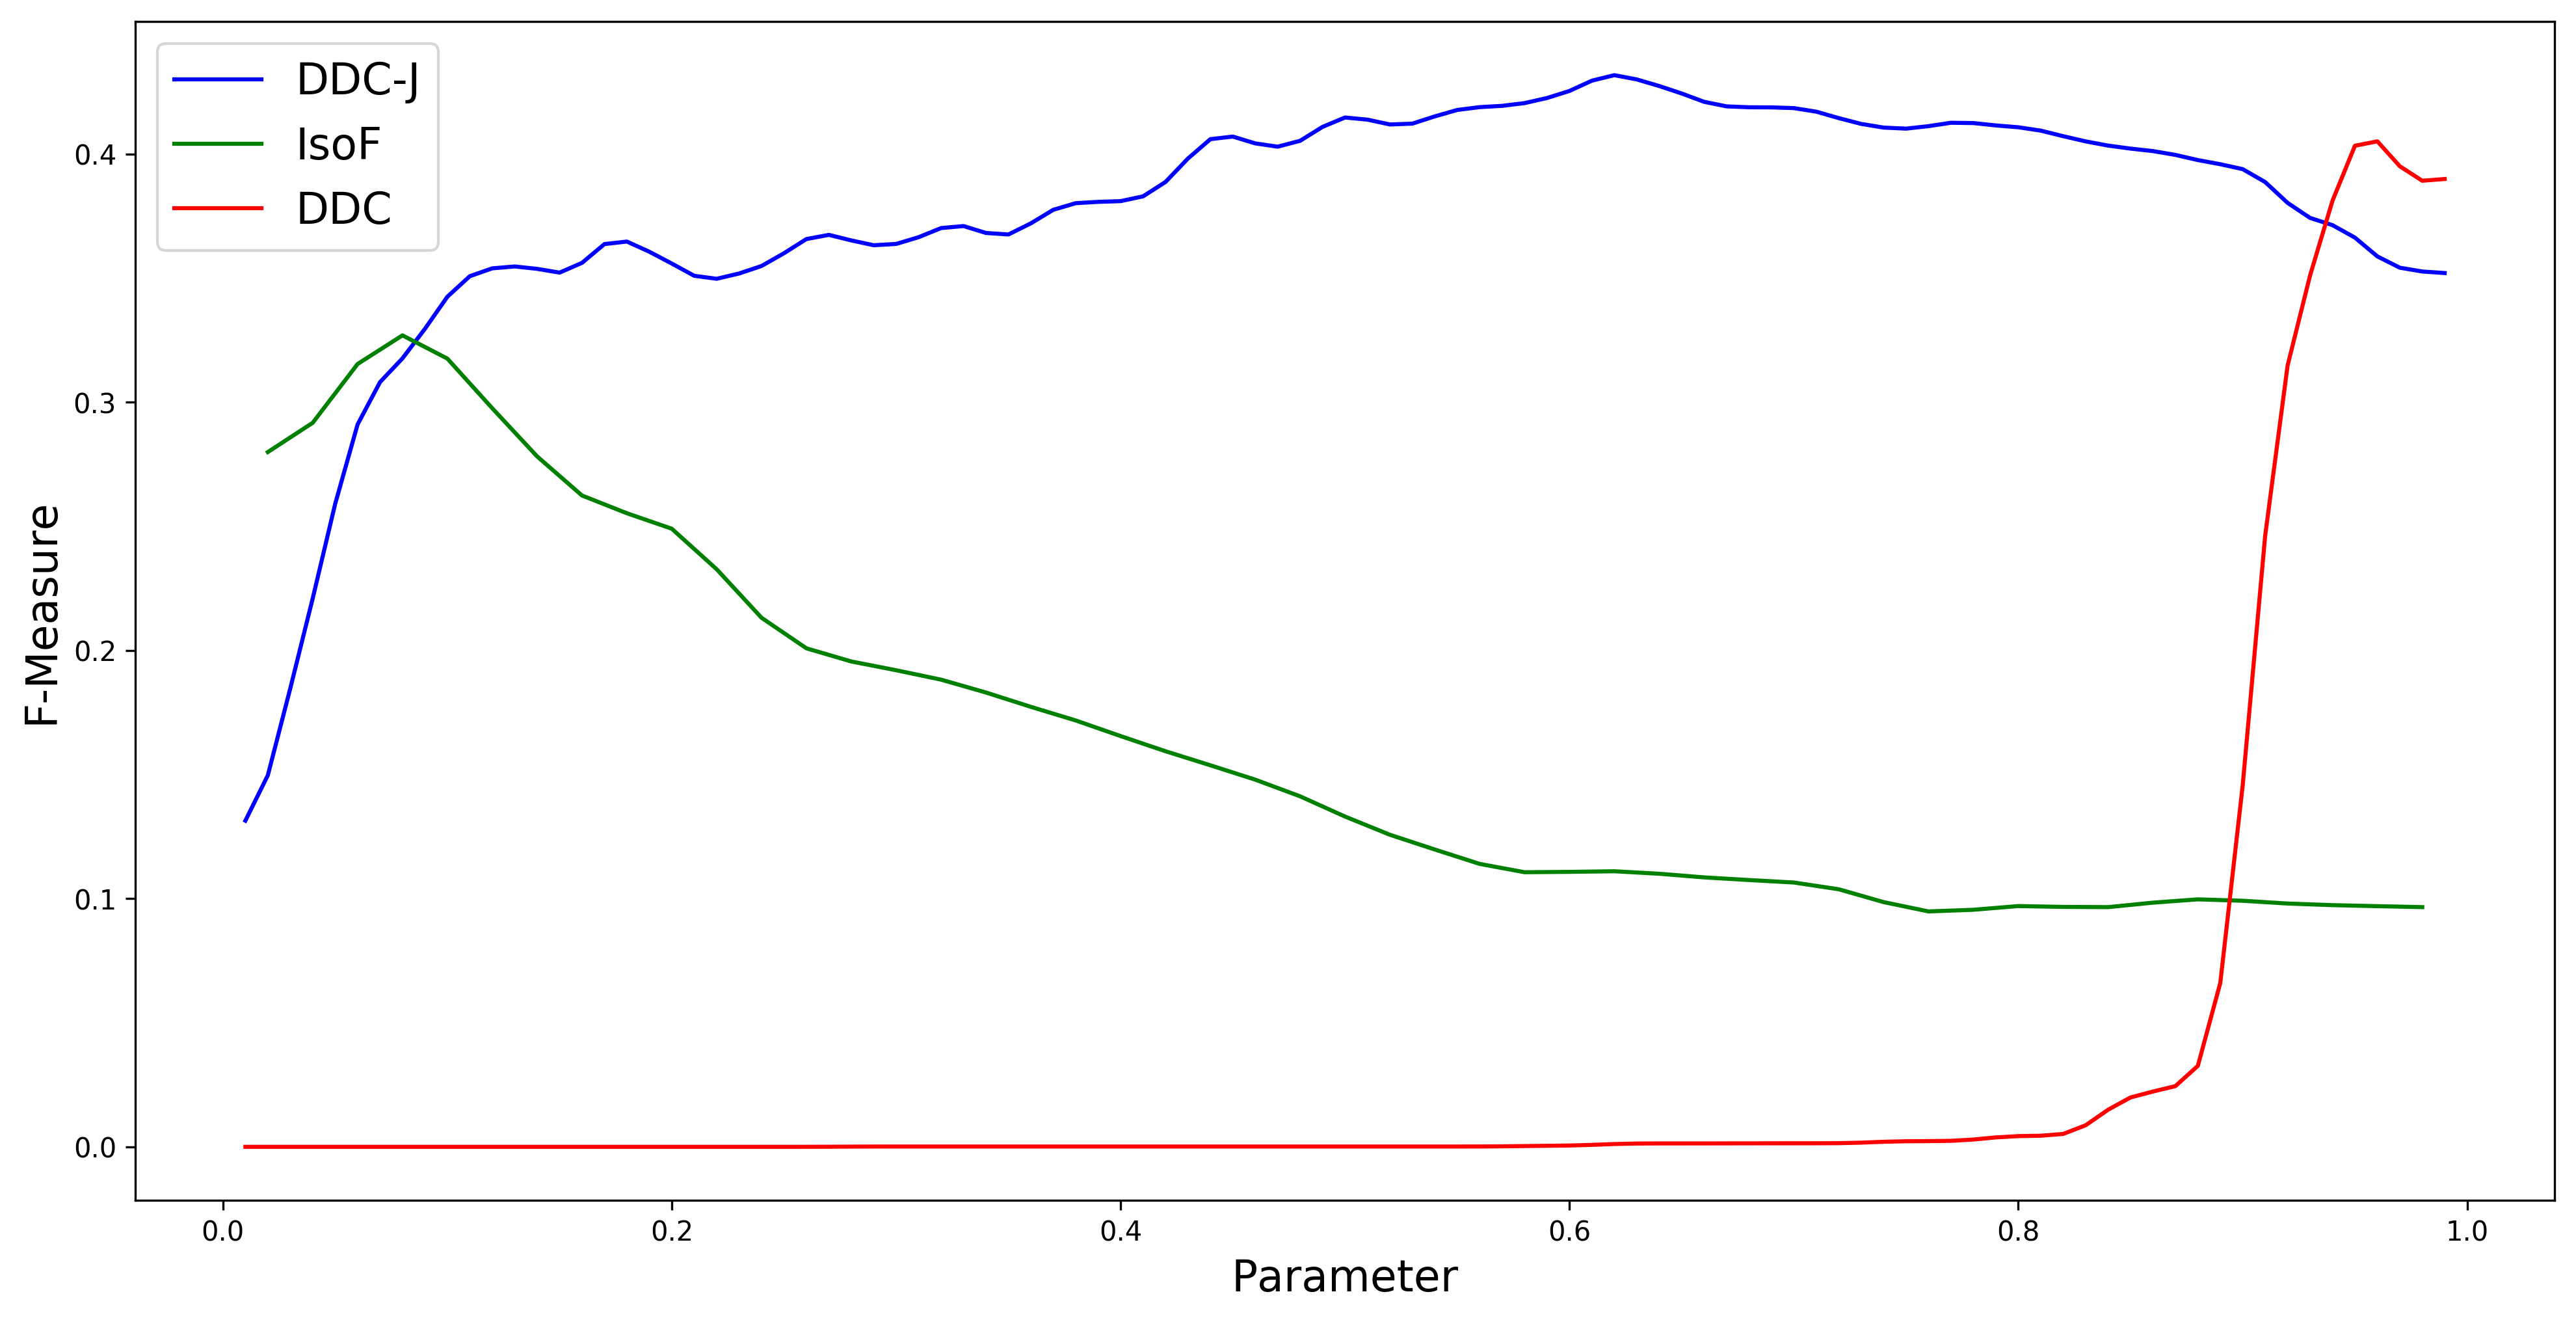

In [7]:
plt.figure(figsize=(16, 8), dpi= 300)
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'k', 'm', 'y', 'c']
methods = ['DDC-J','IsoF','DDC']
for i, m in enumerate(methods):
    smooth_values = smooth(np.asarray(dic_results[m].mean(0).values),25)
    convert_x = np.asarray(dic_results[m].mean(0).index)
    if m == 'IsoF' or m == 'Cov':
        convert_x = convert_x * 2
    plt.plot(convert_x,smooth_values, 
             c=colors[i],label=m)
    print(m,dic_results[m].max(1).mean())

plt.legend(fontsize=16)
plt.xlabel('Parameter', fontsize=16)
plt.ylabel('F-Measure', fontsize=16)
plt.show()